In [136]:
# d for coin futures, f for usd s futures
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import requests as re
import pandas as pd
import numpy as np

COIN_API = 'https://dapi.binance.com'
USD_API = 'https://fapi.binance.com'
SPOT_API = 'https://api.binance.com'
g_api_key='eJBYUpKfnUCA5wXDfJTKGPNaOoyLtnXIb9D6GKFbnABLCndVRRYJrdyI9rMi6D54'
g_secret_key='970sbCiGtH1W4rPW56I4MBbD9brKZegyveedljt3U3D5hry7zMbxa4sxacA80kUv'
headers = {"Accept": "application/json"}

In [137]:
epoch = datetime.utcfromtimestamp(0)
def dt_from_ms(ms):
    return datetime.utcfromtimestamp(int(ms / 1000.0))

def dt_to_ms(dt):
    delta = dt - epoch
    return int(delta.total_seconds() * 1000)

def get_pairs(isCoin):
    suff = '/dapi/v1/exchangeInfo' if isCoin else '/fapi/v1/exchangeInfo'
    url = COIN_API if isCoin else USD_API
    result = re.get(url+suff, headers=headers)
    symbolObjs = result.json()['symbols']
    symbols = [x['symbol'] for x in symbolObjs]
    perpetuals = list(filter(lambda x: 'PERP' in x, symbols))
    futures = list(filter(lambda x: 'PERP' not in x, symbols))
    return {'perpetuals': perpetuals, 'futures': futures}

def get_funding_rate(isCoin, pair, start_date, end_date, limit=1000):
    start_year, start_month, start_day = int(start_date[0:4]), int(start_date[4:6]), int(start_date[6:8])
    end_year, end_month, end_day = int(end_date[0:4]), int(end_date[4:6]), int(end_date[6:8])
    start_date = dt_to_ms(datetime(start_year, start_month, start_day))
    end_date = dt_to_ms(datetime(end_year, end_month, end_day))
    suff = '/dapi/v1/fundingRate' if isCoin else '/fapi/v1/fundingRate'
    suff += '?symbol='+pair+'&startTime='+str(start_date)+'&endTime='+str(end_date)+'&limit='+str(limit)
    url = COIN_API if isCoin else USD_API
    result = re.get(url+suff, headers=headers)
    data = result.json()
    funding_rate, funding_time = [], []
    for funding in data:
        funding_rate.append(float(funding['fundingRate'])*100)
        funding_time.append(dt_from_ms(funding['fundingTime']))
    df = pd.DataFrame({'Time':funding_time,'Rate':funding_rate})
    df['Time'] = pd.to_datetime(df['Time'])
    df.set_index('Time',inplace=True)
    return df

def get_kline_data(isCoin, pair, start_date, end_date, limit=1500, interval='1h', isSpot=False):
    start_year, start_month, start_day = int(start_date[0:4]), int(start_date[4:6]), int(start_date[6:8])
    end_year, end_month, end_day = int(end_date[0:4]), int(end_date[4:6]), int(end_date[6:8])
    start_date = dt_to_ms(datetime(start_year, start_month, start_day))
    end = dt_to_ms(datetime(end_year, end_month, end_day))
    # query from start_date to end_date
    dfs = []
    if interval == '1h':
        time_step = 1*60*60*1000
    elif interval == '1m':
        time_step = 1*60*1000
    elif interval == '1d':
        time_step = 1*24*60*60*1000
    end_date = start_date-time_step
    while (end_date < end):
        start_date = end_date + time_step
        end_date = start_date + (limit-500)*time_step
        if end_date >= end:
            end_date = end
        suff = '/dapi/v1/klines' if isCoin else '/fapi/v1/klines'
        suff = suff if not isSpot else '/api/v3/klines'
        suff += '?symbol='+pair+'&startTime='+str(start_date)+'&endTime='+str(end_date)+'&limit='+str(limit)+'&interval='+interval
        url = COIN_API if isCoin else USD_API
        url = url if not isSpot else SPOT_API
        result = re.get(url+suff, headers=headers)
        data = result.json()
        closePrice, time = [], []
        for ohlc in data:
            closePrice.append(float(ohlc[4]))
            time.append(dt_from_ms(ohlc[0]))
        df = pd.DataFrame({'Time':time,pair:closePrice})
        df['Time'] = pd.to_datetime(df['Time'])
        df.set_index('Time',inplace=True)
        dfs.append(df)
    df_i = dfs[0]
    for df in dfs[1:]:
        df_i = df_i.append(df)
    return df_i

In [138]:
coin_futures = get_pairs(True)
usdt_futures = get_pairs(False)

In [139]:
coin_futures, usdt_futures

({'perpetuals': ['BTCUSD_PERP',
   'ETHUSD_PERP',
   'LINKUSD_PERP',
   'BNBUSD_PERP',
   'TRXUSD_PERP',
   'DOTUSD_PERP',
   'ADAUSD_PERP',
   'EOSUSD_PERP',
   'LTCUSD_PERP',
   'BCHUSD_PERP',
   'XRPUSD_PERP',
   'ETCUSD_PERP',
   'FILUSD_PERP',
   'EGLDUSD_PERP',
   'DOGEUSD_PERP'],
  'futures': ['BTCUSD_210625',
   'BTCUSD_210924',
   'ETHUSD_210625',
   'ETHUSD_210924',
   'ADAUSD_210625',
   'LINKUSD_210625',
   'BCHUSD_210625',
   'DOTUSD_210625',
   'XRPUSD_210625',
   'LTCUSD_210625',
   'BNBUSD_210625',
   'ADAUSD_210924',
   'LINKUSD_210924',
   'BCHUSD_210924',
   'DOTUSD_210924',
   'XRPUSD_210924',
   'LTCUSD_210924',
   'BNBUSD_210924']},
 {'perpetuals': [],
  'futures': ['BTCUSDT',
   'ETHUSDT',
   'BCHUSDT',
   'XRPUSDT',
   'EOSUSDT',
   'LTCUSDT',
   'TRXUSDT',
   'ETCUSDT',
   'LINKUSDT',
   'XLMUSDT',
   'ADAUSDT',
   'XMRUSDT',
   'DASHUSDT',
   'ZECUSDT',
   'XTZUSDT',
   'BNBUSDT',
   'ATOMUSDT',
   'ONTUSDT',
   'IOTAUSDT',
   'BATUSDT',
   'VETUSDT',
   'NEOU

In [140]:
root = 'ADAUSD'
perp = root+'_PERP'
fut1 = root+'_210625'
fut2 = root+'_210926'
isCoin = True
start_date, end_date = '20200926','20210407'
perp_data = get_kline_data(isCoin, perp, start_date, end_date, limit=1500, interval='1h')

In [141]:
fut_data1 = get_kline_data(isCoin, fut1, start_date, end_date, limit=1500, interval='1h')
#fut_data2 = get_kline_data(isCoin, fut2, start_date, end_date, limit=1500, interval='1h')

In [142]:
from copy import deepcopy
data = perp_data.join(fut_data1, how='inner')
cols = data.columns
returns = deepcopy(data)
for c in cols:
    returns[c] = np.log(returns[c]).diff(1)
returns = returns.dropna()

In [143]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
y = returns[[perp]]
x = returns[[fut1]]
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ADAUSD_PERP   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 1.058e+05
Date:                Thu, 08 Apr 2021   Prob (F-statistic):               0.00
Time:                        20:59:41   Log-Likelihood:                 11060.
No. Observations:                2464   AIC:                        -2.212e+04
Df Residuals:                    2462   BIC:                        -2.211e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.032e-05   5.48e-05      0.188      0.851   -9.72e-05       0.000
ADAUSD_210625     0.9669      0.003    325.242      0.000       0.961       0.973
==============================================================================
Omnibus:                      438.829   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5128.475
Skew:                           0.478   Prob(JB):                         0.00
Kurtosis:                      10.003   Cond. No.                         54.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [144]:
mean = (data[perp] - results.params[fut1]*data[fut1]).mean()
std = (data[perp] - results.params[fut1]*data[fut1]).std()

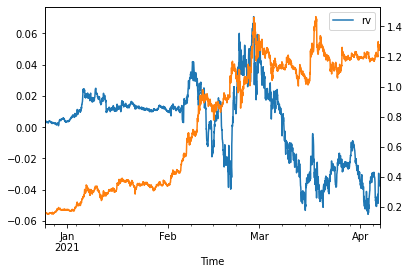

In [145]:
data['rv'] = (data[perp] - results.params[fut1]*data[fut1])
data.plot(y='rv')
data[perp].plot(secondary_y = [perp])

In [146]:
print((data.tail(1)['rv'].values[0] - mean) / std)
print(mean)
print(std)

-1.5653018655038846
0.0016267032585423676
0.024293250483074277


In [147]:
data.pct_change().corr()

,ADAUSD_PERP,ADAUSD_210625,rv
ADAUSD_PERP,1.000000,0.988601,0.029819
ADAUSD_210625,0.988601,1.000000,0.023137
rv,0.029819,0.023137,1.000000


In [148]:
'''
Trades initiated:
BNB rv: 401.224, 370.476 = (370.476-0.96*401.224) = -14.7
ADA rv: 1.2023, 1.29202 = 1.2023 - 0.99*1.29202 = -0.076
'''

'\nTrades initiated:\nBNB rv: 401.224, 370.476 = (370.476-0.96*401.224) = -14.7\nADA rv: 1.2023, 1.29202 = 1.2023 - 0.99*1.29202 = -0.076\n'

In [149]:
funding_rates = {}
perps = coin_futures['perpetuals']
start_date, end_date = '20200101','20210409'
for p in perps:
    tmp = get_funding_rate(True, p, start_date, end_date, limit=1000)
    funding_rates[p] = tmp

In [266]:
# funding rate vs. basis
# btc, eth, bch, ltc, ada, link, dot, xrp, bnb
root = 'BTCUSD'
perp = root+'_PERP'
spot = root+'T'
isCoin = True
start_date, end_date = '20201225','20210326'
endTime = np.datetime64('2021-03-26')
fut = root+'_210326'
perp_data = get_kline_data(isCoin, perp, start_date, end_date, limit=1500, interval='1h')
fut_data1 = get_kline_data(isCoin, fut, start_date, end_date, limit=1500, interval='1h')
spot_data = get_kline_data(isCoin, spot, start_date, end_date, limit=1500, interval='1h',isSpot=True)
data = perp_data.join(fut_data1, how ='inner')
data = data.join(spot_data,how='inner')
funding_rate = funding_rates[perp]
data['basisPct'] = (data[fut] - data[perp]) / data[perp]
# get annualized basis
data['TimeToMaturity'] = data.index - endTime
data['TimeToMaturity'] = list(map(lambda y: -y.astype('timedelta64[h]') / np.timedelta64(24, 'h'), data['TimeToMaturity'].values))
data['AnnualizedBasis'] = 365 * (data['basisPct'] * 100 / data['TimeToMaturity'])
data['basisCoin'] = 1./data[perp] - 1./data[fut]
data['BasisLoss'] = 100*data['basisCoin']*data[spot]
tot = data.join(funding_rate, how='inner')
tot['Rate_r10'] = tot['Rate'].rolling(3*5).mean()
# get annualized rate
tot['AnnualizedRate'] = 365*3*tot['Rate_r10']
tot['AnnualizedReturn'] = tot['AnnualizedRate'] - tot['AnnualizedBasis']
tot['Rate'] /= 100


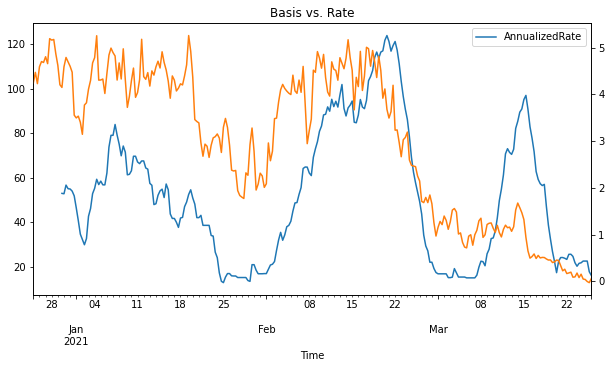

In [267]:
tot.plot(y='AnnualizedRate')
tot['BasisLoss'].plot(secondary_y = ['BasisLoss'], title='Basis vs. Rate', figsize=(10,5))

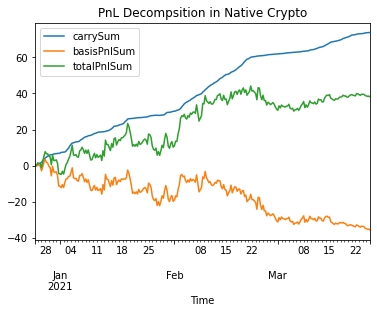

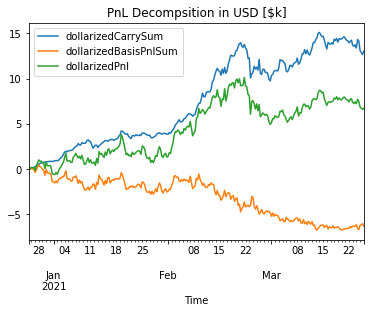

In [152]:
'''IV. How to Calculate the Funding Amount?
Funding is calculated as:
Funding Amount=Nominal Value of Positions* ×Funding Rate
*Nominal Value of Positions = Mark Price x Size of a Contract
'''
def getPnlFromReturns(start, returns):
    pnl = []
    for r in returns:
        pnl_i = r * start
        pnl.append(pnl_i)
        start += pnl_i
    return pnl

# pnl
# assume we buy 100 contracts, 100 USD each for 10000 exposure
# funding rate calculation is 10000 / mark price * funding rate
perp_start = fut_start = 100000
returns = deepcopy(tot)
returns[perp+'_coin'] = -perp_start / returns[perp]
returns[fut+'_coin'] = fut_start / returns[fut]
#returns[perp+'_returns'] = returns[perp].pct_change(1)
#returns[fut+'_returns'] = returns[fut].pct_change(1)
returns[perp+'_returns_coin'] = -returns[perp+'_coin'].diff(1)
returns[fut+'_returns_coin'] = -returns[fut+'_coin'].diff(1)
returnsHedge = deepcopy(returns)
returns = returns.tail(tot.shape[0]-1)
#returns[perp+'_pnl'] = getPnlFromReturns(perp_start, list(returns[perp+'_returns']))
#returns[fut+'_pnl'] = getPnlFromReturns(fut_start, list(returns[fut+'_returns']))
returns['basis_pnl_coin'] = returns[perp+'_returns_coin'] + returns[fut+'_returns_coin']
# carry calculation
returns['carry'] = perp_start/returns[perp] * returns['Rate']

# final pnl calc
returns['carrySum'] = returns['carry'].cumsum()
returns['basisPnlSum'] = returns['basis_pnl_coin'].cumsum()
returns['totalPnlSum'] = returns['carrySum'] + returns['basisPnlSum']
returns.plot(y=['carrySum','basisPnlSum','totalPnlSum'], title='PnL Decompsition in Native Crypto')

returns['dollarizedCarrySum'] = returns['carry'].cumsum() * returns[spot] / 1e3
returns['dollarizedBasisPnlSum'] = returns['basis_pnl_coin'].cumsum() * returns[spot] / 1e3
returns['dollarizedPnl'] = (returns['dollarizedCarrySum'] + returns['dollarizedBasisPnlSum'] )
returns.plot(y=['dollarizedCarrySum','dollarizedBasisPnlSum','dollarizedPnl'], title='PnL Decompsition in USD [$k]')

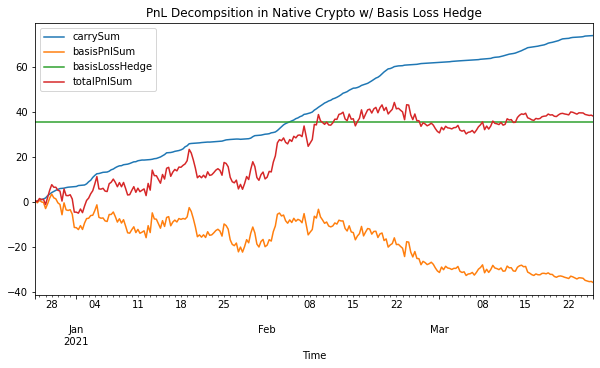

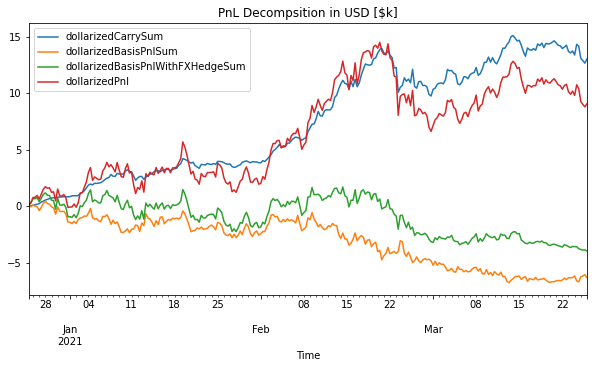

In [153]:
# basis loss in crypto
# we know the loss. we need to hedge a future loss cashlow whose value depends on fx rate.
# a forward / futures can be traded? but the future would need to be usdt futures. b/c the amt is defined.
# if we use coin-M futures there's negative convexity b/c we're long so we got to buy more
# on rally and sell more on sell off

# this is the loss that will acrue over cycle if basis converges
basisLoss = returnsHedge.head(1)[perp+'_coin'].values[0] + returnsHedge.head(1)[fut+'_coin'].values[0] 
returns['basisLossHedge'] = -basisLoss
returns['basisPnlWithHedgeSum'] = returns['basisLossHedge'] + returns['basisPnlSum']
returns['totalPnlSum'] = returns['carrySum']  + returns['basisPnlSum']
returns.plot(y=['carrySum','basisPnlSum','basisLossHedge','totalPnlSum'], title='PnL Decompsition in Native Crypto w/ Basis Loss Hedge',figsize=(10,5))

basisLossDollarized = -basisLoss * returnsHedge.head(1)[spot].values[0]
basisLossReturns = list(returnsHedge[spot].pct_change(1).tail(returnsHedge.shape[0]-1))
returns['dollarizedBasisLossFXHedge'] = getPnlFromReturns(basisLossDollarized, basisLossReturns)
returns['dollarizedBasisLossFXHedge'] = returns['dollarizedBasisLossFXHedge'].cumsum()
returns['dollarizedBasisPnlWithFXHedgeSum'] = returns['dollarizedBasisPnlSum'] + returns['dollarizedBasisLossFXHedge'] / 1e3 
returns['dollarizedPnl'] = (returns['dollarizedCarrySum'] + returns['dollarizedBasisPnlWithFXHedgeSum'] )
returns.plot(y=['dollarizedCarrySum','dollarizedBasisPnlSum','dollarizedBasisPnlWithFXHedgeSum','dollarizedPnl'], title='PnL Decompsition in USD [$k]',figsize=(10,5))
# fix pnl with initial mv

8.833151150015269
0.03235586501837095


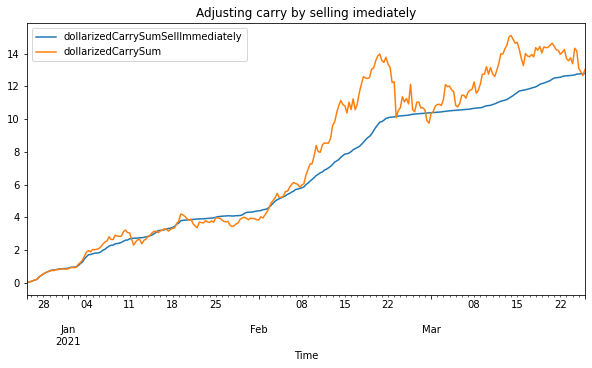

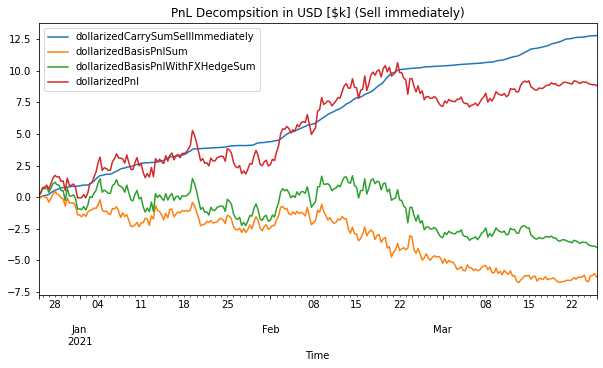

In [154]:
# hedge the carry pnl by selling it immediately
returns['dollarizedCarrySumSellImmediately'] = (returns['carry'] * returns[spot]).cumsum() / 1e3
returns.plot(y=['dollarizedCarrySumSellImmediately','dollarizedCarrySum'], title='Adjusting carry by selling imediately', figsize=(10,5))   

returns['dollarizedPnl'] = (returns['dollarizedCarrySumSellImmediately'] + returns['dollarizedBasisPnlWithFXHedgeSum'] )
returns.plot(y=['dollarizedCarrySumSellImmediately','dollarizedBasisPnlSum','dollarizedBasisPnlWithFXHedgeSum','dollarizedPnl'], title='PnL Decompsition in USD [$k] (Sell immediately)',figsize=(10,5))
pnl = returns.tail(1)['dollarizedPnl'].values[0]
print(pnl)
print(pnl / returns.shape[0])

In [155]:
# the dollarized basis loss hedge hedges the known loss and the unknown fx move
# in theory our basis loss can skyrocket if the market rallies b/c the basis loss is fixed in the native cryptos

# we could break the basis loss hedge pnl into the fx hedge part (vs t0) and the overall value
# the basis loss is somewhat complicated b/c it is random both (1) how the basis converges and (2) the fx rate

In [177]:
# aggregate performances
# funding rate vs. basis
# btc, eth, bch, ltc, ada, link, dot, xrp, bnb
coins = ['BTCUSD','ETHUSD','LTCUSD','BCHUSD','ADAUSD','LINKUSD','DOTUSD','XRPUSD','BNBUSD']
dates = [('20200626','20200925'),('20200925','20201225'),('20201225','20210326'),('20210326','20210625')]
futures = [['20200925','20201225'],['20201225','20210326'],['20210326','20210625'],['20210625','20210924']]
result = {'Coin':[],'Cycle':[],'Future':[],'CycleLength':[],'pnl':[],'carryPnl':[],'basisPnl':[],'pnlSellCarry':[],'carryPnlSell':[]}
for i in range(len(dates)):
    start_date,end_date = dates[i][0], dates[i][1]
    for coin in coins:
        for future in futures[i]:
            root = coin
            perp = root+'_PERP'
            fut = root+'_'+future[2:]
            spot = root+'T'
            isCoin = True
            #start_date, end_date = '20201225','20210326'
            try:
                perp_data = get_kline_data(isCoin, perp, start_date, end_date if end_date != '20210625' else '20210407', limit=1500, interval='1h')
                fut_data1 = get_kline_data(isCoin, fut, start_date, end_date if end_date != '20210625' else '20210407', limit=1500, interval='1h')
                spot_data = get_kline_data(isCoin, spot, start_date, end_date if end_date != '20210625' else '20210407', limit=1500, interval='1h',isSpot=True)
            except:
                continue
            data = perp_data.join(fut_data1, how ='inner')
            data = data.join(spot_data,how='inner')
            if data.empty: continue
            result['Future'].append(future)
            result['Coin'].append(coin)
            result['Cycle'].append(end_date)
            funding_rate = funding_rates[perp]
            data['basisPx'] = data[fut] - data[perp]
            data['basisPct'] = (data[fut] - data[perp]) / data[perp]
            data['basisCoin'] = 1./data[perp] - 1./data[fut]
            data['basisCoinDollarized'] = data['basisCoin'] * data[spot]
            tot = data.join(funding_rate, how='inner')
            tot['Rate'] /= 100

            perp_start = fut_start = 100000
            returns = deepcopy(tot)
            result['CycleLength'].append(returns.shape[0])
            returns[perp+'_coin'] = -perp_start / returns[perp]
            returns[fut+'_coin'] = fut_start / returns[fut]
            #returns[perp+'_returns'] = returns[perp].pct_change(1)
            #returns[fut+'_returns'] = returns[fut].pct_change(1)
            returns[perp+'_returns_coin'] = -returns[perp+'_coin'].diff(1)
            returns[fut+'_returns_coin'] = -returns[fut+'_coin'].diff(1)
            returnsHedge = deepcopy(returns)
            returns = returns.tail(tot.shape[0]-1)
            #returns[perp+'_pnl'] = getPnlFromReturns(perp_start, list(returns[perp+'_returns']))
            #returns[fut+'_pnl'] = getPnlFromReturns(fut_start, list(returns[fut+'_returns']))
            returns['basis_pnl_coin'] = returns[perp+'_returns_coin'] + returns[fut+'_returns_coin']
            # carry calculation
            returns['carry'] = perp_start/returns[perp] * returns['Rate']

            # final pnl calc
            returns['carrySum'] = returns['carry'].cumsum()
            returns['basisPnlSum'] = returns['basis_pnl_coin'].cumsum()
            returns['totalPnlSum'] = returns['carrySum'] + returns['basisPnlSum']
            returns['dollarizedCarrySum'] = returns['carry'].cumsum() * returns[spot] / 1e3
            returns['dollarizedBasisPnlSum'] = returns['basis_pnl_coin'].cumsum() * returns[spot] / 1e3
            returns['dollarizedPnl'] = (returns['dollarizedCarrySum'] + returns['dollarizedBasisPnlSum'] )

            # this is the loss that will acrue over cycle if basis converges
            basisLoss = returnsHedge.head(1)[perp+'_coin'].values[0] + returnsHedge.head(1)[fut+'_coin'].values[0] 
            returns['basisLossHedge'] = -basisLoss
            returns['basisPnlWithHedgeSum'] = returns['basisLossHedge'] + returns['basisPnlSum']
            returns['totalPnlSum'] = returns['carrySum']  + returns['basisPnlSum']

            basisLossDollarized = -basisLoss * returnsHedge.head(1)[spot].values[0]
            basisLossReturns = list(returnsHedge[spot].pct_change(1).tail(returnsHedge.shape[0]-1))
            returns['dollarizedBasisLossFXHedge'] = getPnlFromReturns(basisLossDollarized, basisLossReturns)
            returns['dollarizedBasisLossFXHedge'] = returns['dollarizedBasisLossFXHedge'].cumsum()
            returns['dollarizedBasisPnlWithFXHedgeSum'] = returns['dollarizedBasisPnlSum'] + returns['dollarizedBasisLossFXHedge'] / 1e3 
            returns['dollarizedPnl'] = (returns['dollarizedCarrySum'] + returns['dollarizedBasisPnlWithFXHedgeSum'] )

            returns['dollarizedCarrySumSellImmediately'] = (returns['carry'] * returns[spot]).cumsum() / 1e3
            returns['dollarizedPnlSellImmediately'] = (returns['dollarizedCarrySumSellImmediately'] + returns['dollarizedBasisPnlWithFXHedgeSum'] )

            pnlSellImmediately = returns.tail(1)['dollarizedPnlSellImmediately'].values[0]
            pnl = returns.tail(1)['dollarizedPnl'].values[0]
            carryPnl = returns.tail(1)['dollarizedCarrySum'].values[0]
            basisPnl = returns.tail(1)['dollarizedBasisPnlWithFXHedgeSum'].values[0]
            carryPnlSell = returns.tail(1)['dollarizedCarrySumSellImmediately'].values[0]
            print(pnlSellImmediately)
            print(pnl)
            result['pnl'].append(pnl)
            result['carryPnl'].append(carryPnl)
            result['basisPnl'].append(basisPnl)
            result['pnlSellCarry'].append(pnlSellImmediately)
            result['carryPnlSell'].append(carryPnlSell)


-1.1322768148942486
-1.2395389781779893
-1.8099839769726236
-1.9172461402563643
-0.9634484809421155
-1.2924826121150794
-2.500751602280523
-2.8297857334534866
-0.3782271896563209
-0.4651551421539149
-0.13571239920207745
-0.14232264013048912
1.5358445140238755
0.32245079590791326
1.7771390010210124
1.7417718383406036
2.7468049497926916
4.6449593464712535
6.147253409719853
8.033122912805478
2.881793220252592
3.9757002955643106
5.652299477487617
6.738138558943003
-0.12029731879887673
0.05400822899736313
0.7074584417365335
0.8817639895327734
0.8284668636800874
0.7696315300777048
0.946034155357967
0.8871988217555844
0.4083788439722549
0.5507559943330151
1.6026024579359144
1.7380073827345168
0.02925008040832955
-0.35120612153997044
1.2423239432380728
0.8598039941778214
1.7909533225815608
1.8133733671339896
3.5184762961263703
3.540896340678799
-2.0025701913883034
-1.8249532464712024
-6.373686706091046
-6.196069761173945
4.407614679221179
4.6626136662135425
5.085636391517106
5.34063537850947
8

In [180]:
# pnl decomposition of past cycles
#result_df = pd.DataFrame(result)
#result_df['CycleLength'] /= 3
results_df = pd.read_csv('./results/perpTrade.csv')
def set_pandas_display_options() -> None:
    """Set pandas display options."""
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 1000
    display.max_colwidth = 199
    display.width = 1000
    # display.precision = 2  # set as needed

set_pandas_display_options()
result_df.round(1)

,Coin,Cycle,Future,CycleLength,pnl,carryPnl,basisPnl,pnlSellCarry,carryPnlSell
0,BTCUSD,20200925,20200925,45.0,-1.2,0.9,-2.1,-1.1,1.0
1,BTCUSD,20200925,20201225,45.0,-1.9,0.9,-2.8,-1.8,1.0
2,ETHUSD,20200925,20200925,38.0,-1.3,0.8,-2.1,-1.0,1.1
3,ETHUSD,20200925,20201225,38.0,-2.8,0.8,-3.6,-2.5,1.1
4,ADAUSD,20200925,20200925,30.0,-0.5,-0.6,0.2,-0.4,-0.6
5,ADAUSD,20200925,20201225,19.0,-0.1,-0.9,0.7,-0.1,-0.9
6,LINKUSD,20200925,20200925,37.0,0.3,2.4,-2.1,1.5,3.7
7,LINKUSD,20200925,20201225,19.0,1.7,0.4,1.4,1.8,0.4
8,BTCUSD,20201225,20201225,90.7,4.6,6.3,-1.6,2.7,4.4
9,BTCUSD,20201225,20210326,90.3,8.0,6.2,1.8,6.1,4.4


In [179]:
#result_df.to_csv('./results/perpTrade.csv')

In [261]:
# projecting pnl
ntnl = 100000
results = {'Coin':[],'FrontBasisLoss':[],'BackBasisLoss':[],'CarryR5':[],'CarryR30':[],'CarryR90':[],'CarryTot':[]}
resultsAnnualized = {'Coin':[],'FrontBasisLoss':[],'BackBasisLoss':[],'CarryR5':[],'CarryR30':[],'CarryR90':[],'CarryTot':[],'CarryMean':[],'ReturnFront':[],'ReturnBack':[]}
start_date, end_date = '20210326','20210410'
endTime = np.datetime64('2021-06-25')
coins = ['BTCUSD','ETHUSD','LTCUSD','BCHUSD','ADAUSD','LINKUSD','DOTUSD','XRPUSD','BNBUSD']
for coin in coins:
    print(coin)
    root = coin
    perp = root+'_PERP'
    fut = root+'_210625'
    fut1 = root+'_210924'
    spot = root+'T'
    isCoin = True
    perp_data = get_kline_data(isCoin, perp, start_date, end_date, limit=1500, interval='1h')
    fut_data1 = get_kline_data(isCoin, fut, start_date, end_date, limit=1500, interval='1h')
    fut_data2 = get_kline_data(isCoin, fut1, start_date, end_date, limit=1500, interval='1h')
    spot_data = get_kline_data(isCoin, spot, start_date, end_date, limit=1500, interval='1h',isSpot=True)
    data = perp_data.join(fut_data1, how ='inner')
    data = data.join(fut_data2, how ='inner')
    data = data.join(spot_data,how='inner')
    funding_rate = funding_rates[perp]
    data['basisPx'] = data[fut] - data[perp]
    data['basisPct'] = (data[fut] - data[perp]) / data[perp]
    data['basisCoinFrontDollarized'] = ntnl * (1./data[fut] - 1./data[perp])*data[spot] / 1e3
    data['basisCoinBackDollarized'] = ntnl * (1./data[fut1] - 1./data[fut])*data[spot] / 1e3
    
    currTime = data.index[-1]
    funding_rate = funding_rates[perp]
    funding_rate[perp+'_r5'] = funding_rate['Rate'].rolling(3*5).mean()
    funding_rate[perp+'_r30'] = funding_rate['Rate'].rolling(3*30).mean()
    funding_rate[perp+'_r90'] = funding_rate['Rate'].rolling(3*90).mean()
    funding_rate['mean'] = funding_rate['Rate'].mean()
    r5, r30, r90, mean = funding_rate[perp+'_r5'].values[-1],funding_rate[perp+'_r30'].values[-1],funding_rate[perp+'_r90'].values[-1],funding_rate['mean'].values[-1]
    timeToMaturity = (endTime - currTime)/ np.timedelta64(24, 'h')
    results['Coin'].append(root)
    results['FrontBasisLoss'].append(data['basisCoinFrontDollarized'].tail(1).values[-1])
    results['BackBasisLoss'].append(data['basisCoinBackDollarized'].tail(1).values[-1])
    results['CarryR5'].append(r5*timeToMaturity*3*ntnl / 100 / 1e3)
    results['CarryR30'].append(r30*timeToMaturity*3*ntnl / 100 / 1e3)
    results['CarryR90'].append(r90*timeToMaturity*3*ntnl / 100 / 1e3)
    results['CarryTot'].append(mean*timeToMaturity*3*ntnl / 100 / 1e3) 
    
    resultsAnnualized['Coin'].append(root)
    front = data['basisCoinFrontDollarized'].tail(1).values[-1] / (ntnl/1000) * 365/timeToMaturity * 100
    back = data['basisCoinBackDollarized'].tail(1).values[-1] / (ntnl/1000) * 365/timeToMaturity * 100
    resultsAnnualized['FrontBasisLoss'].append(front)
    resultsAnnualized['BackBasisLoss'].append(back)
    resultsAnnualized['CarryR5'].append(r5*365*3)
    resultsAnnualized['CarryR30'].append(r30*365*3)
    resultsAnnualized['CarryR90'].append(r90*365*3)
    resultsAnnualized['CarryTot'].append(mean*365*3)
    resultsAnnualized['CarryMean'].append(365*(r5+r30+mean))
    resultsAnnualized['ReturnFront'].append(365*(r5+r30+mean)+front)
    resultsAnnualized['ReturnBack'].append(365*(r5+r30+mean)+back)
result_df = pd.DataFrame(results).round(1)
resultAnnualized_df = pd.DataFrame(resultsAnnualized).round(1)




BTCUSD
ETHUSD
LTCUSD
BCHUSD
ADAUSD
LINKUSD
DOTUSD
XRPUSD
BNBUSD


In [262]:
resultAnnualized_df

,Coin,FrontBasisLoss,BackBasisLoss,CarryR5,CarryR30,CarryR90,CarryTot,CarryMean,ReturnFront,ReturnBack
0,BTCUSD,-33.0,-23.1,50.1,49.6,50.2,30.6,43.4,10.4,20.3
1,ETHUSD,-33.1,-23.3,57.7,50.1,54.5,34.4,47.4,14.3,24.1
2,LTCUSD,-33.3,-18.8,79.6,61.0,54.5,36.5,59.0,25.7,40.2
3,BCHUSD,-33.0,-22.7,45.1,44.2,43.9,30.7,40.0,7.1,17.3
4,ADAUSD,-22.5,-22.0,87.9,77.0,59.2,25.8,63.6,41.0,41.6
5,LINKUSD,-26.0,-18.1,79.6,45.1,30.9,25.0,49.9,23.9,31.8
6,DOTUSD,-35.3,-25.3,67.7,56.4,61.0,41.3,55.2,19.8,29.8
7,XRPUSD,-27.7,-18.0,78.8,70.3,57.4,28.5,59.2,31.5,41.2
8,BNBUSD,-34.2,-28.7,67.1,58.2,56.3,25.8,50.4,16.2,21.7


In [713]:
# clearly the best time to trade is when the basis is tight or flipped (never) and rates are high
# there is a positive correlation between the basis and the funding rate
# is this due to liquidity or something fundamental?
regData = deepcopy(returns)
regData['Rate'] *= 100
n = 10
regData['Rate_r'+str(n)] = regData['Rate'].rolling(10).mean()
regData['basisPct_r'+str(n)] = regData['basisPct'].rolling(10).mean()
regData = regData.tail(regData.shape[0]-n)

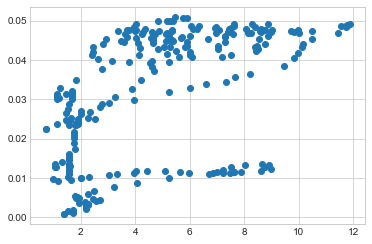

In [714]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
lastTime = returns.tail(1).index[0]
regData['TimeToMaturity'] = regData.index - lastTime
regData['TimeToMaturity'] = list(map(lambda y: -y.astype('timedelta64[h]') / np.timedelta64(24, 'h'), regData['TimeToMaturity'].values))

# study the relationship between time to maturity, rate, and basis. Basis is a function of maturity and rate.
plt.scatter(regData['Rate_r'+str(n)]*100, regData['basisPct_r'+str(n)], marker='o')

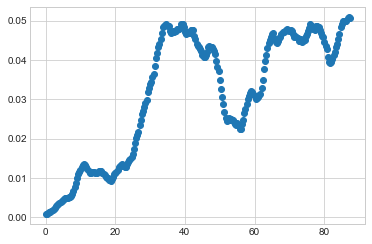

In [715]:
plt.scatter(regData['TimeToMaturity'], regData['basisPct_r'+str(n)], marker='o')

In [716]:
y = regData[['basisPct']]
x = regData[['Rate_r'+str(n),'TimeToMaturity']]
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               basisPct   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     692.0
Date:                Thu, 08 Apr 2021   Prob (F-statistic):          7.57e-105
Time:                        00:44:08   Log-Likelihood:                 943.68
No. Observations:                 263   AIC:                            -1881.
Df Residuals:                     260   BIC:                            -1871.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0045      0.001     -4.332      0.000      -0.007      -0.002
Rate_r10           0.2765      0.014     19.232      0.000       0.248       0.305
TimeToMaturity     0.0005   1.64e-05     30.368      0.000       0.000       0.001
==============================================================================
Omnibus:                        4.027   Durbin-Watson:                   0.256
Prob(Omnibus):                  0.134   Jarque-Bera (JB):                2.680
Skew:                           0.017   Prob(JB):                        0.262
Kurtosis:                       2.507   Cond. No.                     1.75e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

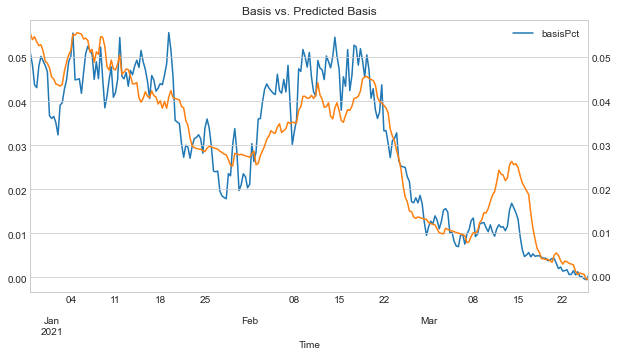

In [717]:
regData['predictedBasis'] = results.predict()
regData.plot(y='basisPct')
regData['predictedBasis'].plot(secondary_y = ['predictedBasis'], title='Basis vs. Predicted Basis', figsize=(10,5))

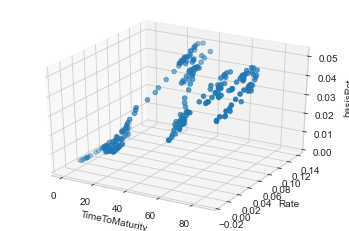

In [704]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Data for a three-dimensional line
zline = regData['basisPct_r'+str(n)]
xline = regData['TimeToMaturity']
yline = regData['Rate_r'+str(n)]
ax.scatter(xline, yline, zline,marker='o')
ax.set_xlabel('TimeToMaturity')
ax.set_ylabel('Rate')
ax.set_zlabel('basisPct')

plt.show()

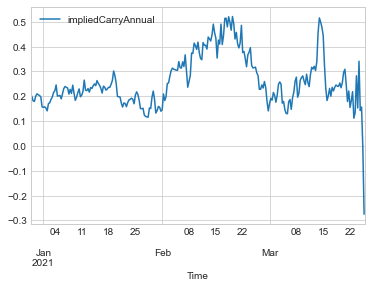

In [735]:
# the analytical formula for futures is
# spot price * e^(carry * t)
# we can solve for carry Futures = Spot*e^(r*t) --> ln(fut/spot) = r*t -> r = 1/t * ln(fut/spot)
regData['impliedCarryAnnual'] = np.log(regData[fut]/regData[perp]) * (365./(regData['TimeToMaturity']))
regData['RateAnnual'] = regData['Rate']*3*365
regData['impliedCarryCycle'] = np.log(regData[fut]/regData[perp])
regData.plot(y='impliedCarryAnnual')

# implied carry bakes basis + time to maturity into a signal. use this in regression? get carry rate (thus futurees price
# from time to maturity and rate

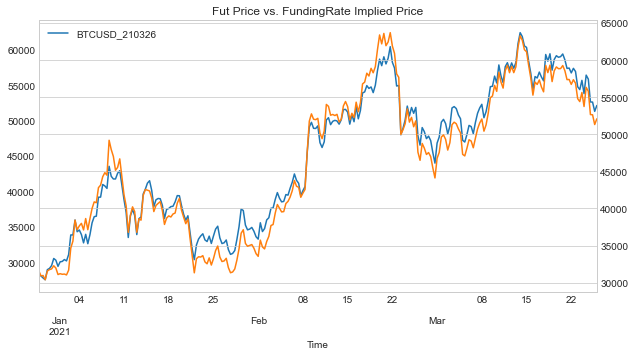

In [736]:
import math
regData['rateImpliedFutPrice'] = regData[spot]*math.e**((regData['Rate_r'+str(n)]*3/100.) * regData['TimeToMaturity'])
regData.plot(y=fut)
regData['rateImpliedFutPrice'].plot(secondary_y = ['rateImpliedFutPrice'], title='Fut Price vs. FundingRate Implied Price', figsize=(10,5))

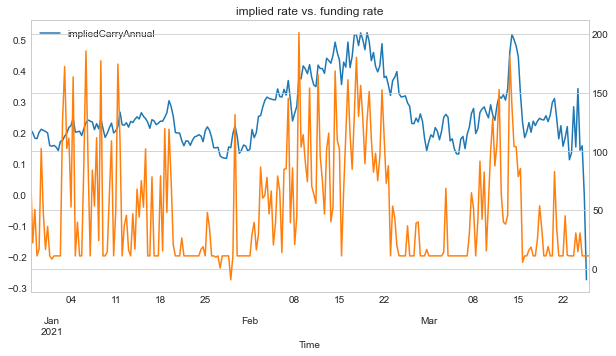

In [740]:
# can look at implied rate vs funding rate to see what market expects rates will do
regData.plot(y='impliedCarryAnnual')
regData['RateAnnual'].plot(secondary_y = ['RateAnnual'], title='implied rate vs. funding rate', figsize=(10,5))